## Importing Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torcheval.metrics import MulticlassAccuracy

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc


## Data Preprocessing 

In [2]:
# Define paths for train, validation, and test sets
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

# Define transformations without any augmentation, only resizing, converting to tensor, and normalizing
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for consistency with model input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization 
])

train_augementation = transforms.Compose ([
    transforms.Resize((256, 256)),  # Resize images to a fixed size
    transforms.RandomRotation(45),  # Randomly rotate images within 30 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Width and height shift (fraction of total size)
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),  # Random zoom (analogous to zoom_range)
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet values
])

# Load datasets from directories 
train_dataset = datasets.ImageFolder(train_dir, transform=train_augementation)
val_dataset = datasets.ImageFolder(val_dir, transform=common_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=common_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=48, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=48, shuffle=False, num_workers=4)

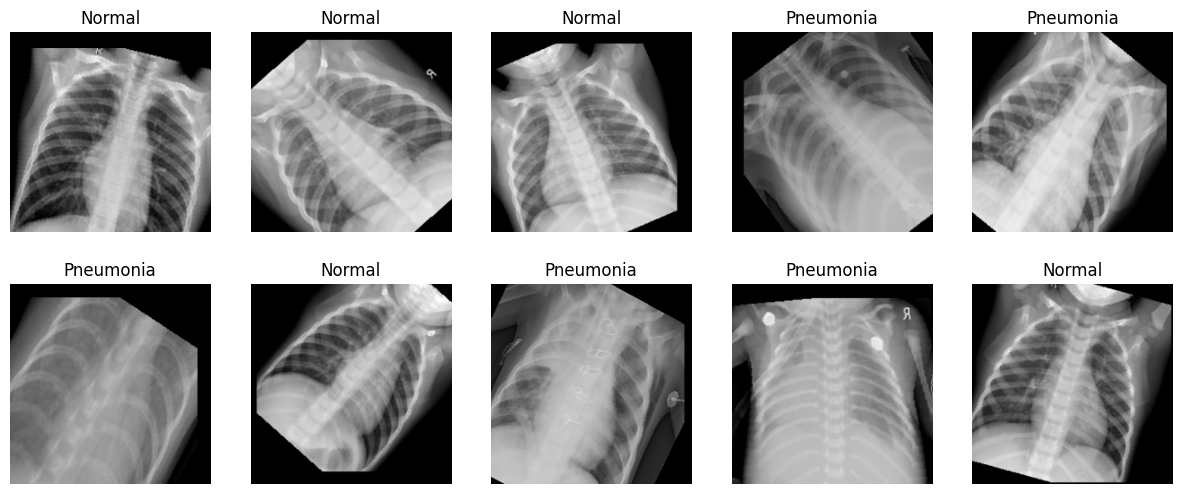

In [3]:
# Get a batch of images from the train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Define the number of images to display in the grid
num_images = 10
num_cols = 5  # Number of columns in the grid
num_rows = num_images // num_cols  # Calculate rows based on total images

# Display the images in a grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

# Convert images to numpy and display
for i in range(num_images):
    ax = axes[i // num_cols, i % num_cols]
    img = images[i].numpy().transpose((1, 2, 0))  # Convert from Tensor to numpy
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip values to keep them between 0 and 1 for display

    ax.imshow(img)
    ax.axis('off')
    ax.set_title("Pneumonia" if labels[i] == 1 else "Normal")

plt.show()


## Training The Model

### Implementing Resnet-50

In [4]:
# Load the pre-trained ResNet-50 model using the updated weights argument
weights = ResNet50_Weights.IMAGENET1K_V1  
model = resnet50(weights=weights)

# Modify the fully connected layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Output 1 logit for binary classification
nn.init.xavier_uniform_(model.fc.weight)
# model.fc.bias.fill_(0)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()
print(device)

cuda


In [5]:
# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassAccuracy

threshold = 0.5

# Lists to store training and validation losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 100
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    thresh_output = None
    target = None

    # Training Loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        toutput = (outputs.squeeze() > threshold).type(torch.int32)  # Apply threshold
        tget = labels.type(torch.int32)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate thresholded outputs and targets
        if thresh_output is None:
            thresh_output = toutput
            target = tget
        else:
            thresh_output = torch.cat([thresh_output, toutput], dim=0)
            target = torch.cat([target, tget], dim=0)

        running_loss += loss.cpu().item()

    # Calculate training accuracy
    metric = MulticlassAccuracy(num_classes=2)
    metric.update(thresh_output, target)
    train_acc = metric.compute()
    train_acc = train_acc.cpu().item()
    train_accuracies.append(train_acc)  # Store training accuracy

    # Average training loss for the epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Store training loss
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

    # Validation Loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    thresh_output = None
    target = None
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)

            # Forward pass
            outputs = model(inputs)
            toutput = (outputs.squeeze() > threshold).type(torch.int32)  # Apply threshold
            tget = labels.type(torch.int32)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()
            
            # Accumulate thresholded outputs and targets
            if thresh_output is None:
                thresh_output = toutput
                target = tget
            else:
                thresh_output = torch.cat([thresh_output, toutput], dim=0)
                target = torch.cat([target, tget], dim=0)

    # Calculate validation accuracy
    metric = MulticlassAccuracy(num_classes=2)
    metric.update(thresh_output, target)
    val_acc = metric.compute()
    val_acc = val_acc.cpu().item()
    val_accuracies.append(val_acc)  # Store validation accuracy

    # Average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)  # Store validation loss
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

# Plot Training and Validation Losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# threshold = 0.5

# # Lists to store training and validation losses for each epoch
# train_losses = []
# val_losses = []

# epochs = 100
# for epoch in range(epochs):
#     model.train()  # Set model to training mode
#     running_loss = 0.0
#     thresh_output = None
#     target = None

#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)

#         # Zero the gradients
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(inputs)
#         toutput = F.threshold(outputs.squeeze(), threshold, 1.0).type(torch.int32)
#         tget = labels.type(torch.int32)
#         loss = criterion(outputs.squeeze(), labels)

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
        
#         if thresh_output is None:
#             thresh_output = toutput
#             target = tget
#         else:
#             thresh_output = torch.cat([thresh_output, toutput], dim=0)
#             target = torch.cat([target, tget], dim=0)

#         running_loss += loss.cpu().item()

#     # Average training loss for the epoch
#     metric = MulticlassAccuracy(num_classes=2)
#     metric.update(thresh_output, target)
#     train_acc = metric.compute()
#     train_acc = train_acc.cpu().item()
#     avg_train_loss = running_loss / len(train_loader)
#     train_losses.append(avg_train_loss)  # Store training loss for this epoch
#     print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}")

#     # Validation loop
#     model.eval()  # Set model to evaluation mode
#     val_loss = 0.0
#     thresh_output = None
#     target = None
#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)

#             # Forward pass
#             outputs = model(inputs)
#             toutput = F.threshold(outputs.squeeze(), threshold, 1.0).type(torch.int32)
#             tget = labels.type(torch.int32)
#             loss = criterion(outputs.squeeze(), labels)
#             val_loss += loss.item()
            
#             if thresh_output is None:
#                 thresh_output = toutput
#                 target = tget
#             else:
#                 thresh_output = torch.cat([thresh_output, toutput], dim=0)
#                 target = torch.cat([target, tget], dim=0)

#     metric = MulticlassAccuracy(num_classes=2)
#     metric.update(thresh_output, target)
#     val_acc = metric.compute()
#     val_acc = val_acc.cpu().item()
#     # Average validation loss for the epoch
#     avg_val_loss = val_loss / len(val_loader)
#     val_losses.append(avg_val_loss)  # Store validation loss for this epoch
#     print(f"Validation Loss: {avg_val_loss:.4f}")

# # Plot Training and Validation Losses
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')
# plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='s')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training Loss vs Validation Loss')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# Evaluate on the test set
model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).squeeze()  # Apply sigmoid to get probabilities
        preds = (probs > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)

        # Store predictions, probabilities, and labels
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)  # Use probabilities for AUC

print(f"Test Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)  # Use probabilities for ROC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
torch.save(model.state_dict(), "pneumonia_resnet50.pth")